## CDPT model from Arredondo & Billen, 2016

This is a simplified compositional dependent phase-transition model generated for modeling subduction-zone geodynamics.
It is designed to function with a Bousinesq approximation (i.e. incompressible).

Please refer to the original paper, and use its reference to the phase transitions.

[link to the paper](http://dx.doi.org/10.1016/j.jog.2016.05.009)

### contents

figures 1A, B, C are reproduced.

figure 1A is compared with pyrolite model from the Chust 17 model.

In [1]:
import json
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# utility functions

# point ot a line
def compute_point_to_line (temperature, depth, T, P, W, slope, by_depth, is_negative, is_vertical):
    '''
    In this approach, we define a transition as a solid line and a range.
    The solid line is a rigid boundary for the new phase.
    While the range is a width of transition. 
    '''
    deviation = 0.0
    if (is_vertical):
        deviation = temperature - T
    else:
        deviation = depth - P - slope * (temperature - T)
    # In this approach, a transition must has a direction in defination
    # We need an opposite direction when the transition defined from higher pressure to lower pressure.
    if (is_negative):
        deviation *= -1.0
    # Deviation must be smaller than 2*W, value for function would be 0.04 there.
    is_in = (deviation > -2.0 * W)
    return [is_in, deviation]


# phases
def compute_phases_properties(phase_index, temperature, depth, 
                              densities, transition_depths, transition_temperatures,\
                              transition_widths, transition_slopes):
    pressure_depth_derivative = 3400 * 10.0  #
    
    index_410 = 0 
    index_520 = 1 
    index_560 = 2 
    index_660 = 3 
    index_660_gt = 4 
    index_660_gt1 = 5 
    index_660_gt_combined = 6 
    
    ## initiate varibles 
    function_value = 0.0
    phase_index_pyrolite = 0
    
    
    ## 410
    d410 = transition_depths[index_410]
    T410 = transition_temperatures[index_410]
    W410 = transition_widths[index_410]
    slope410 = transition_slopes[index_410]
    result410 = compute_point_to_line(temperature, depth, T410, d410, W410,\
                                      slope410/pressure_depth_derivative, True, False, False)
    
    ## 520
    d520 = transition_depths[index_520]
    T520 = transition_temperatures[index_520]
    W520 = transition_widths[index_520]
    slope520 = transition_slopes[index_520]
    result520 = compute_point_to_line(temperature, depth, T520, d520, W520,\
                                      slope520/pressure_depth_derivative, True, False, False)
        
    ## 560
    d560 = transition_depths[index_560]
    T560 = transition_temperatures[index_560]
    W560 = transition_widths[index_560]
    slope560 = transition_slopes[index_560]
    result560 = compute_point_to_line(temperature, depth, T560, d560, W560,\
                                   slope560/pressure_depth_derivative, True, False, False)
        
    ## 660
    d660 = transition_depths[index_660]
    T660 = transition_temperatures[index_660]
    W660 = transition_widths[index_660]
    slope660 = transition_slopes[index_660]
    result660 = compute_point_to_line(temperature, depth, T660, d660, W660,\
                                      slope660/pressure_depth_derivative, True, False, False)
        
    ## 660 for gt, part 0
    d660_gt = transition_depths[index_660_gt]
    T660_gt = transition_temperatures[index_660_gt]
    W660_gt = transition_widths[index_660_gt]
    slope660_gt = transition_slopes[index_660_gt]
    result660_gt = compute_point_to_line(temperature, depth, T660_gt, d660_gt, W660_gt,\
                                         slope660_gt/pressure_depth_derivative, True, False, False)
        
    ## 660 for gt, part 1 
    d660_gt1 = transition_depths[index_660_gt1]
    T660_gt1 = transition_temperatures[index_660_gt1]
    W660_gt1 = transition_widths[index_660_gt1]
    slope660_gt1 = transition_slopes[index_660_gt1]
    result660_gt1 = compute_point_to_line(temperature, depth, T660_gt1, d660_gt1, W660_gt1,\
                                          slope660_gt1/pressure_depth_derivative, True, False, False)
        
    ## 660 for gt, combined
    ##  phase_index_660 = 0
    d660_gt_combined = transition_depths[index_660_gt_combined]
    T660_gt_combined = transition_temperatures[index_660_gt_combined]
    W660_gt_combined = transition_widths[index_660_gt_combined]
    slope660_gt_combined = transition_slopes[index_660_gt_combined]
    result660_gt_combined = compute_point_to_line(temperature, depth, T660_gt_combined, d660_gt_combined,\
                                                  W660_gt_combined, slope660_gt_combined/pressure_depth_derivative,\
                                                  True, False, False)
    
    
    if (result410[0]):
        ## 410 for pyrolite
        if(phase_index == index_410):
            function_value += 0.5*(1.0 + np.tanh(result410[1]/W410))
    
    if (result520[0]):
        # 520 for pyrolite
        if(phase_index == index_520):
            function_value += 0.5*(1.0 + np.tanh(result520[1]/W520))
    
    if (result560[0]):
        # 560 for pyrolite, Gt -> CaPv + Gt
        if(phase_index == index_560):
            function_value += 0.5*(1.0 + np.tanh(result560[1]/W560))
    
    if (result660[0]):
        # 660 for pyrolite, rw -> brg + fp
        if(phase_index == index_660):
            function_value += 0.5*(1.0 + np.tanh(result660[1]/W660))
    
    if (result660_gt[0] and temperature < T660_gt):
        # 660 for pyrolite, gt -> il
        if(phase_index == index_660_gt):
            function_value += 0.5*(1.0 + np.tanh(result660_gt[1]/W660_gt))
    
    if (result660_gt1[0] and temperature < T660_gt1):
        # 660 for pyrolite, il -> brg
        if(phase_index == index_660_gt1):
            function_value += 0.5*(1.0 + np.tanh(result660_gt1[1]/W660_gt1))
    
    if (result660_gt_combined[0] and temperature >= T660_gt_combined):
      # 660 for pyrolite combined, at higher temperature, gt -> brg
        if(phase_index == index_660_gt_combined):
            function_value += 0.5*(1.0 + np.tanh(result660_gt_combined[1]/W660_gt_combined))
    
    return function_value

### Inputs for one phase transition include the depths, temperatures, widths, slopes of the transition.

For details, refer to table 1 in the paper.

In [3]:
# Compute composition density with a constant temperature
# values for phase transition properties
# pyrolite (mantle)
number_of_phase_transitions = 7
transition_depths = [410e3, 520e3, 560e3, 670e3, 670e3, 670e3, 670e3]
transition_temperatures = [1662.0, 1662.0, 1662.0, 1662.0, 1662.0, 1662.0, 1662.0]
transition_widths = [13e3, 25e3, 60e3, 5e3, 5e3, 5e3, 50e3]
transition_slopes = [4e6, 4.1e6, 4e6, -2e6, 4e6, -3.1e6, 1.3e6]
# values of these densities are not important, the difference is
phase_densities = [3300.0, 3394.4, 3442.1, 3453.2, 3617.6, 3691.5, 3774.7, 3929.1]

n = 100
temperature = 1620.0
depths = np.linspace(0, 2890e3, n)
densities = np.zeros(n)
phase_function_values = np.zeros(number_of_phase_transitions)

j = 0
for depth in depths:
    density = phase_densities[0]
    for i in range(number_of_phase_transitions):
        phase_function_values[i] = compute_phases_properties(i, temperature, depth, phase_densities, transition_depths,
                                                  transition_temperatures, transition_widths, transition_slopes)
    for i in range(number_of_phase_transitions):
        density += phase_function_values[i] * (phase_densities[i+1] - phase_densities[i])
    densities[j] = density
    j += 1

In [4]:
# harzburgite
number_of_phase_transitions = 7
transition_depths = [410e3, 520e3, 560e3, 670e3, 670e3, 670e3, 670e3]
transition_temperatures = [1662.0, 1662.0, 1662.0, 1662.0, 1662.0, 1662.0, 1662.0]
transition_widths = [13e3, 25e3, 60e3, 5e3, 5e3, 5e3, 50e3]
transition_slopes = [4e6, 4.1e6, 4e6, -2e6, 4e6, -3.1e6, 1.3e6]
# values of these densities are not important, the difference is
phase_densities = [3235.0, 3372.3, 3441.7, 3441.7, 3680.8, 3717.8, 3759.4, 3836.6]

temperature = 1000  # compute at cold slab condition
depths = np.linspace(0, 2890e3, n)
densities1 = np.zeros(n)
phase_function_values = np.zeros(number_of_phase_transitions)

j = 0
for depth in depths:
    density = phase_densities[0]
    for i in range(number_of_phase_transitions):
        phase_function_values[i] = compute_phases_properties(i, temperature, depth, phase_densities, transition_depths,
                                                  transition_temperatures, transition_widths, transition_slopes)
    for i in range(number_of_phase_transitions):
        density += phase_function_values[i] * (phase_densities[i+1] - phase_densities[i])
    densities1[j] = density
    j += 1

### eclogite transitions

I still use the function defined above to compute phase transition for eclogite.
This is tecnically wrong because eclogite has A MgSiO2 and a SiO2 system and the SiO2 system is not involved.
However, the density could be toned to present similar density jumps, as is the approach in the paper.

In [5]:
# eclogite
# eclogite phase-transition parameters
number_of_phase_transitions = 7
transition_depths = [410e3, 520e3, 665e3, 670e3, 720e3, 720e3, 720e3]
transition_temperatures = [1662.0, 1662.0, 1662.0, 1662.0, 1662.0, 1662.0, 1662.0]
transition_widths = [5e3, 5e3, 160e3, 5e3, 20e3, 20e3, 20e3]
transition_slopes = [4e6, 4.1e6, 4e6, -2e6, 1.3e6, 1.3e6, 1.3e6]
# values of these densities are not important, the difference is
phase_densities = [3540.0, 3540.0, 3540.0, 3618.3, 3618.3, 3901.9, 3901.9, 3901.9]

temperature = 1000.0  # computed at cold slab condition
depths = np.linspace(0, 2890e3, n)
densities2 = np.zeros(n)
phase_function_values = np.zeros(number_of_phase_transitions)

j = 0
for depth in depths:
    density = phase_densities[0]
    for i in range(number_of_phase_transitions):
        phase_function_values[i] = compute_phases_properties(i, temperature, depth, phase_densities, transition_depths,
                                                  transition_temperatures, transition_widths, transition_slopes)
    for i in range(number_of_phase_transitions):
        density += phase_function_values[i] * (phase_densities[i+1] - phase_densities[i])
    densities2[j] = density
    j += 1

## Lithosphere density

lithosphere is 7.5 km-thick crust and 37.5 km-thick harzburgite, thus its density is the average of these two.

In [6]:
# Oceanic lithosphere
hc = 7.5e3
hhz = 27.7e3
densities3 = (hhz * densities1 + hc * densities2) / (hc + hhz)

### Now, plot density profile, compare with output from fisrt principal observation and seismic observation
A profile of pyrolite model from Chust et al 17 paper is included for comparison.
Here is doi of the original paper:
10.1002/2017JB014501.
The meaning of this comparison is the see the density different around the phase transitions.
Meanwhile, it serves to illustrate the difference between a EBA and a real mantle.

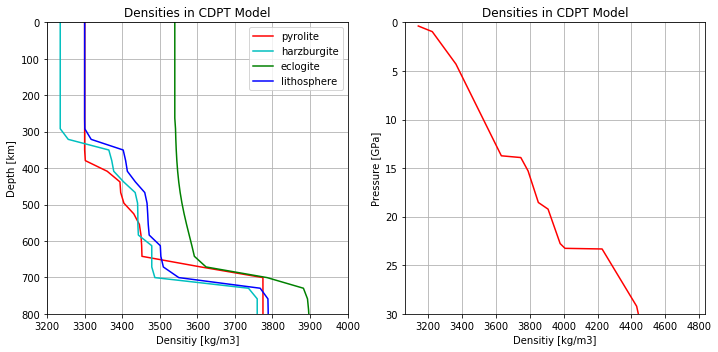

In [7]:


# data from Chust 17
Chust17_pyrolite = np.array([
  [0.37078107742533817, 3.1425201813692216], 
  [0.950936590564412, 3.2249689538700497],
  [4.289074088639609, 3.3645200063366243],
  [13.733855181574159, 3.6325618236181016],
  [13.913762104113376, 3.7473406677161245],
  [15.29053749408711, 3.7902418219342437],
  [18.542044934634184, 3.850878430998938],
  [19.224893623385242, 3.908204043696113],
  [22.7711869758023, 3.9795712587613234],
  [23.26083512704819, 4.008218112771951],
  [23.325863060256637, 4.227045194967481],
  [29.223242999526967, 4.430894804301371],
  [54.81555663135366, 4.7545978736862855]
])

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
# pyrolite
axs[0].set_xlim([3200, 4000])
axs[0].set_ylim([0, 800])
axs[0].set_ylabel('Depth [km]')
axs[0].set_xlabel('Densitiy [kg/m3]')
axs[0].invert_yaxis()
axs[0].set_title("Densities in CDPT Model")
axs[0].grid()

# pyrolite
axs[0].plot(densities, depths/1e3, 'r', label='pyrolite')
# harzburgite
axs[0].plot(densities1, depths/1e3, 'c', label='harzburgite')
# eclogite
axs[0].plot(densities2, depths/1e3, 'g', label='eclogite')
# lithosphere
axs[0].plot(densities3, depths/1e3, 'b', label='lithosphere')
# layout
axs[0].legend()
# pyrolite from the Chust 17 paper
axs[1].set_title("Densities in Chust 17 paper")
# axs[0].set_xlim([3200, 4000])
axs[1].set_ylim([0, 30])
axs[1].set_ylabel('Pressure [GPa]')
axs[1].set_xlabel('Densitiy [kg/m3]')
axs[1].invert_yaxis()
axs[1].set_title("Densities in CDPT Model")
axs[1].grid()
axs[1].plot(Chust17_pyrolite[:, 1]*1e3, Chust17_pyrolite[:, 0], 'r', label='Chust 17 pyrolite model')
fig.tight_layout()

### pyrolite slab

The parameterization for this part is identical to the pyrolite mantle except a colder temperature assumed.

In [8]:
# Compute composition density with a constant temperature
# values for phase transition properties
# pyrolite (mantle)
number_of_phase_transitions = 7
transition_depths = [410e3, 520e3, 560e3, 670e3, 670e3, 670e3, 670e3]
transition_temperatures = [1662.0, 1662.0, 1662.0, 1662.0, 1662.0, 1662.0, 1662.0]
transition_widths = [5e3, 5e3, 5e3, 5e3, 5e3, 5e3, 5e3]
transition_slopes = [4e6, 4.1e6, 4e6, -2e6, 4e6, -3.1e6, 1.3e6]
# values of these densities are not important, the difference is
phase_densities = [3300.0, 3394.4, 3442.1, 3453.2, 3617.6, 3691.5, 3774.7, 3929.1]

n = 100
temperature = 1000.0
depths = np.linspace(0, 2890e3, n)
densities4 = np.zeros(n)
phase_function_values = np.zeros(number_of_phase_transitions)

j = 0
for depth in depths:
    density = phase_densities[0]
    for i in range(number_of_phase_transitions):
        phase_function_values[i] = compute_phases_properties(i, temperature, depth, phase_densities, transition_depths,
                                                  transition_temperatures, transition_widths, transition_slopes)
    for i in range(number_of_phase_transitions):
        density += phase_function_values[i] * (phase_densities[i+1] - phase_densities[i])
    densities4[j] = density
    j += 1

## Buoyancy of the slab

The bouyancy of the slab is derived from a 100 km thick slab
At first, we assume the slab to be composed of a single composition. 
At this stage, I compute for the three composition respectively and reproduce figure 1B.
Then, a different assumption is adapted that the slab is composed of 7.5km-thick eclogite and 27.7 km thick harzburgite, 64.8 km

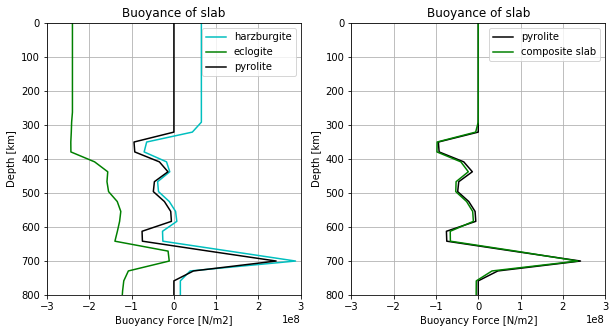

In [9]:
grav_acc = 10
slab_width = 100e3

# density anamoly & buoyancy of the harzburgite layer
diff_densities1 = densities1 - densities
buo1 = - diff_densities1 * grav_acc * slab_width
# density anamoly & buoyancy of the crustal layer
diff_densities2 = densities2 - densities
buo2 = - diff_densities2 * grav_acc * slab_width
# density anamoly & buoyancy of the pyrolite slab layer
diff_densities4 = densities4 - densities
buo4 = - diff_densities4 * grav_acc * slab_width

# density anamoly & buoyancy of the pyrolite slab layer
hpr = 64.8e3
buoS = - (diff_densities1 * hhz + diff_densities2 * hc + diff_densities4 * hpr) * grav_acc

# plot
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].set_xlim([-3e8, 3e8])
axs[0].set_ylim([0, 800])
axs[0].set_ylabel('Depth [km]')
axs[0].set_xlabel('Buoyancy Force [N/m2]')
axs[0].invert_yaxis()
axs[0].set_title("Buoyance of slab")
axs[0].grid()
axs[0].plot(buo1, depths/1e3, 'c', label='harzburgite')
axs[0].plot(buo2, depths/1e3, 'g', label='eclogite')
axs[0].plot(buo4, depths/1e3, 'k', label='pyrolite')
axs[0].legend()
# second plot
axs[1].set_xlim([-3e8, 3e8])
axs[1].set_ylim([0, 800])
axs[1].set_ylabel('Depth [km]')
axs[1].set_xlabel('Buoyancy Force [N/m2]')
axs[1].invert_yaxis()
axs[1].set_title("Buoyance of slab")
axs[1].grid()
axs[1].plot(buo4, depths/1e3, 'k', label='pyrolite')
axs[1].plot(buoS, depths/1e3, 'g', label='composite slab')
axs[1].legend()